## Motivation

We aim at building a fully autonomous adaptive HA device, where an ultra-low-power PGM processor (1-10 mW) inside the hearing aid hosts the RL agent


Following “good regulator” theorem, if an agent is to regulate the state of its environment efficiently (e.g. satisfy a user), then it must internalize a model of its
environment. The environment can be represented by a probabilistic model. Depending on the task (the objective of the application) the model will differ. In this notebook we consider speech enhancement task meaning that we need a model to encode the speech signal.

Before we move on the model specification, we have to settle on a signal representation. 
Most common ones are: frequency, time-frequency, and time domain representations.  We are make us of the latter type of the representation of an audio signal (*waveform modelling currently seems to be the dominant approach in the generative setting; "Generating music in the waveform domain" Sander Dieleman*) 


It turns out that time-varying AR model (**TVAR**) is a good representation of a speech signal:

\begin{align}  &\mathbf{x}_t = A(\theta_{t})\mathbf{x}_{t-1} + \mathbf{c}v_{t} \\ &y_t = \mathbf{c}^{\top} \mathbf{x}_{t} + w_t \end{align} where 

\begin{align} &v_t \sim \mathcal{N}(0, \gamma^{-1}) \\ &w_t \sim \mathcal{N}(0, \tau^{-1}) \end{align} are process and measurement noise respectively.

For this state space model we can build a corresponding generative probabilistic distribution.


┌ Info: Precompiling QuartzImageIO [dca85d43-d64c-5e67-8c65-017450d5d020]
└ @ Base loading.jl:1260


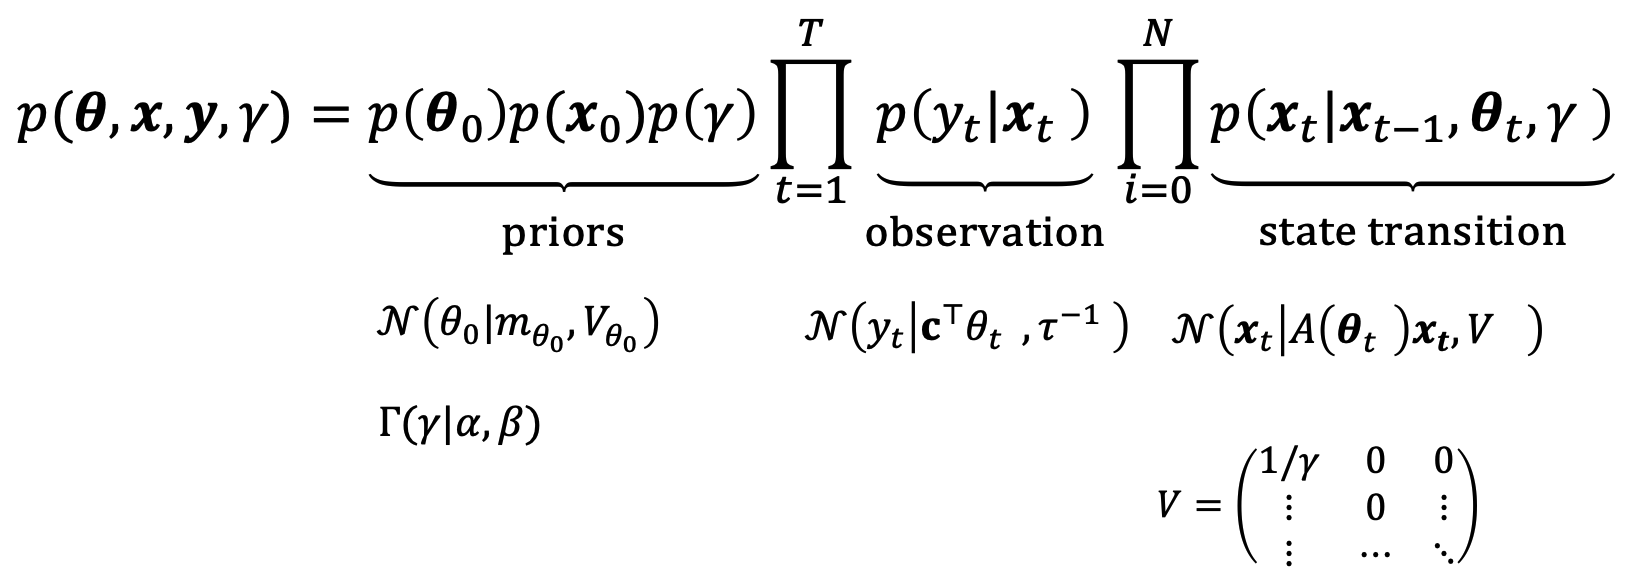

In [3]:
using Images
img = load("img/model.png")

The central quantity of interest is the following posterior, given all observations up to time $t$, which fully describes our knowledge regarding the parameters of the model.

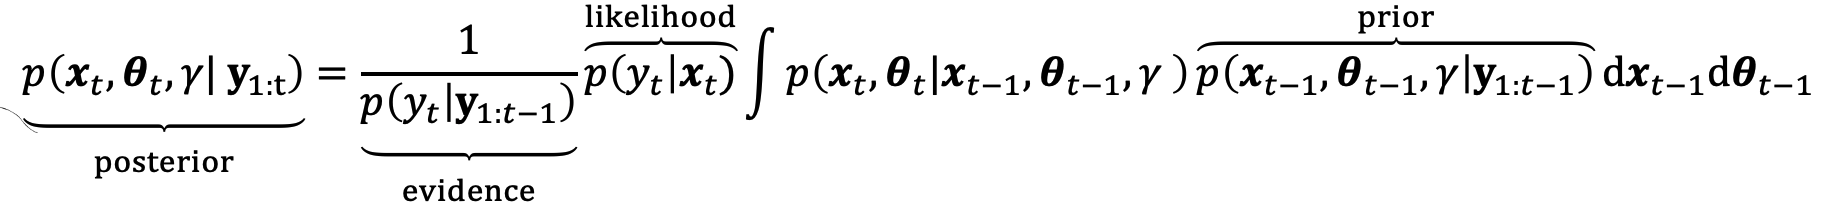

In [5]:
img = load("img/bayse.png")

In order to approximate the posterior we employ variational message passing (**VMP**)
DISCLAIMER: we use informative prior for measurement noise precision $\tau$

In [6]:
##
using ForneyLab
import ForneyLab: unsafeMean, unsafeCov, unsafeMeanCov, Multivariate
using LAR.Node
using LAR.Data
using ProgressMeter
using LinearAlgebra
using Plots
using Dates
using WAV

┌ Info: Precompiling LAR [c3bc7fac-5998-4d64-8961-b7df36e0e4ce]
└ @ Base loading.jl:1260
┌ Warning: Package LAR does not have ForneyLab in its dependencies:
│ - If you have LAR checked out for development and have
│   added ForneyLab as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with LAR
└ Loading ForneyLab into LAR from project dependency, future warnings for LAR are suppressed.


In [17]:
# clean speech
cl, fs = wavread("speech/clean.wav")

# white noise
wn = sqrt(0.0001)*randn(length(cl))
# noised speech
ns = cl .+ wn
wavwrite(ns, "speech/noised.wav")

## Speech Signals

### clean

In [24]:
using SampledSignals
# clean speech
buf_cl = SampleBuf{Float64, 2}(cl, fs)

21119-frame, 1-channel SampleBuf{Float64, 2}
2.639875s sampled at 8000.0Hz
▁▁▁▁▁▂▅▅▅▅▅▅▆▆▆▆▆▆▅▄▅▅▄▄▄▄▂▄▆▆▆▆▆▆▆▅▄▅▅▅▄▆▆▆▆▅▄▅▅▅▆▅▅▅▅▆▆▆▆▃▃▁▁▄▄▅▅▅▄▂▃▂▂▂▂▂▂▁▁▁

### noised

In [26]:
# noised speech
buf_ns = SampleBuf{Float64, 2}(ns, fs)

21119-frame, 1-channel SampleBuf{Float64, 2}
2.639875s sampled at 8000.0Hz
▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▅▄▅▆▅▄▄▅▄▄▆▆▆▆▆▆▆▅▅▅▅▅▄▆▆▆▆▅▄▅▅▅▆▆▅▅▅▆▆▆▆▄▄▄▄▄▄▅▅▅▄▄▄▄▄▄▄▄▄▄▄▄

In [27]:
# dividing into 10ms frames with 2.5ms overlap
start = 1
l = Int(0.01*fs)
overlap = Int(0.0025*fs)
totseg = Int(ceil(length(ns)/(l-overlap)))
segment = zeros(totseg, l)
zseg = zeros(totseg, l)
for i in 1:totseg - 1
    global start
    segment[i,1:l]=ns[start:start+l-1]
    zseg[i, 1:l] = cl[start:start+l-1]
    start = (l-overlap)*i+1
end
segment[totseg, 1:length(ns)-start+1] = ns[start:length(ns)]
zseg[totseg, 1:length(cl)-start+1] = cl[start:length(cl)]
n_samples = l;

80

### Creating graph

In [35]:
# Building the model

ARorder = 10

fg = FactorGraph()

# State prior
@RV x_0 ~ GaussianMeanVariance(placeholder(:m_x_0, dims=(ARorder, )),
                               placeholder(:v_x_0, dims=(ARorder, ARorder)))

@RV θ ~ GaussianMeanVariance(placeholder(:m_θ, dims=(ARorder, )),
                             placeholder(:v_θ, dims=(ARorder, ARorder)))

@RV γ ~ Gamma(placeholder(:a_γ), placeholder(:b_γ))

@RV τ ~ Gamma(placeholder(:a_τ), placeholder(:b_τ))

# Transition and observation model
x = Vector{Variable}(undef, n_samples)
y = Vector{Variable}(undef, n_samples)

c = zeros(ARorder); c[1] = 1.0

x_i_min = x_0
for i in 1:n_samples
    
    @RV x[i] ~ Autoregressive(θ, x_i_min, γ)

    @RV y[i] ~ GaussianMeanPrecision(dot(c, x[i]), τ)

    # Data placeholder
    placeholder(y[i], :y, index=i)

    # Reset state for next step
    x_i_min = x[i]
end

In [36]:
# Introducing instrumental distribution (structured states time)
q = PosteriorFactorization(x_0, x, γ, θ, τ, ids=[:X0 :X :Γ :Θ :T])
algo = variationalAlgorithm(q, free_energy=true)
src_code = algorithmSourceCode(algo, free_energy=true)
eval(Meta.parse(src_code));

In [121]:
# VMP iterations
vmp_its = 10

# Storage for results
fe = zeros(totseg, vmp_its)

rmx = zeros(totseg, l)
rvx = zeros(totseg, l)

rmθ = zeros(totseg, ARorder)
rvθ = zeros(ARorder, ARorder, totseg)

rγ = zeros(totseg)
rτ = zeros(totseg)

# Priors
m_x_min_0 = randn(ARorder)
v_x_min_0 = diagm(ones(ARorder))
m_θ_min_0 = randn(ARorder)
v_θ_min_0 = diagm(ones(ARorder))
a_γ_0 = 1.0
b_γ_0 = 0.001
a_τ_0 = 1.0
b_τ_0 = 0.001;

In [122]:
@showprogress for segnum in 1:totseg
    global rmx, rvx, rmθ, rvθ, rγ, m_x_min_0, v_x_min_0, m_θ_min_0, v_θ_min_0, a_γ_0, b_γ_0, a_τ_0, b_τ_0, vmp_its

    obs = segment[segnum, :]
    n_samples = length(ns)

    data = Dict(:y => obs, :m_x_0 => m_x_min_0, :v_x_0 => v_x_min_0,
                :m_θ => m_θ_min_0, :v_θ => v_θ_min_0,
                :a_γ => a_γ_0, :b_γ => b_γ_0, :a_τ => a_τ_0, :b_τ => b_τ_0)

    # Initial posterior factors
    marginals = Dict{Symbol, ProbabilityDistribution}()
    marginals[:θ] = ProbabilityDistribution(ForneyLab.Multivariate, GaussianMeanVariance, m=m_θ_min_0, v=v_θ_min_0)
    marginals[:γ] = ProbabilityDistribution(ForneyLab.Gamma, a=a_γ_0, b=b_γ_0)
    marginals[:τ] = ProbabilityDistribution(ForneyLab.Gamma, a=a_τ_0, b=b_τ_0)
    for i in 0:n_samples
        marginals[:x_*i] = ProbabilityDistribution(ForneyLab.Multivariate, GaussianMeanVariance, m=zeros(ARorder), v=diagm(ones(ARorder)))
    end

    # Run algorithm
    for i in 1:vmp_its
        stepX0!(data, marginals)
        stepX!(data, marginals)
        stepΘ!(data, marginals)
        stepΓ!(data, marginals)
        fe[segnum, i] = freeEnergy(data, marginals)
    end

    m_x = [unsafeMean(marginals[Symbol("x_$(i+1)_x_$(i)")])[1] for i in 2:length(obs)-1]
    v_x = [unsafeCov(marginals[Symbol("x_$(i+1)_x_$(i)")])[1] for i in 2:length(obs)-1]
    insert!(m_x, 1, unsafeMean(marginals[:x_1])[1])
    insert!(m_x, 1, unsafeMean(marginals[:x_0])[1])
    insert!(v_x, 1, unsafeCov(marginals[:x_1])[1])
    insert!(v_x, 1, unsafeCov(marginals[:x_0])[1])

    rmx[segnum, :], rvx[segnum, :] = m_x, v_x
    rmθ[segnum, :], rvθ[:, :, segnum] = unsafeMeanCov(marginals[:θ])
    rγ[segnum] = unsafeMean(marginals[:γ])
    rτ[segnum] = unsafeMean(marginals[:τ])

    m_x_min_0, v_x_min_0 = unsafeMean(marginals[:x_*ARorder]), unsafeCov(marginals[:x_*ARorder])
    m_θ_min_0, v_θ_min_0 = zeros(ARorder), diagm(ones(ARorder))

end

Progress: 100%|█████████████████████████████████████████| Time: 0:03:33


# Results

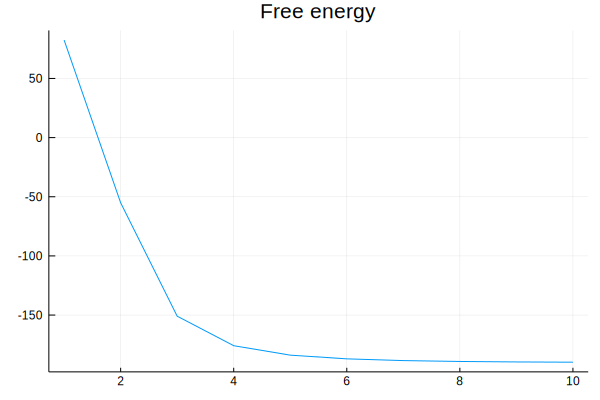

In [131]:
FE = collect(Iterators.flatten(sum(fe, dims=1) ./ n_samples))
plot(FE, title="Free energy", legend=false)

In [132]:
Iterators.flatten(sum(fe, dims=1) ./ n_samples)

Base.Iterators.Flatten{Array{Float64,2}}([82.42949316852392 -55.07577088098649 … -189.61604753516684 -189.84520449927078])

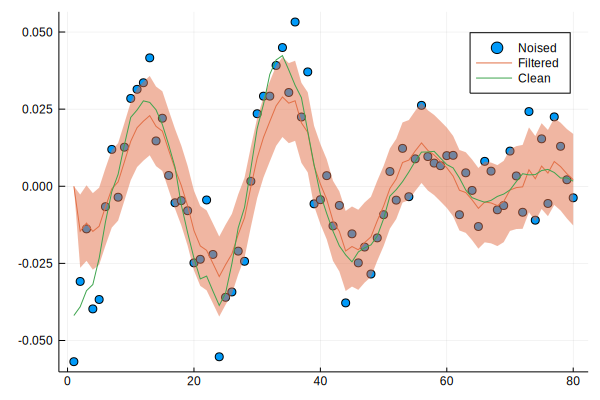

In [150]:
# Plotting segment
segnum = 173

scatter(segment[segnum, :], label="Noised")
plot!(rmx[segnum, :], ribbon=sqrt.(rvx[segnum,:]), label="Filtered")
plot!(zseg[segnum, :], label="Clean")

In [151]:
# Reconstructing the signal
cleanSpeech = zeros(length(ns))
cleanSpeech[1:l] = rmx[1, 1:l]
start = l + 1
for i in 2:totseg - 1
    global start
    cleanSpeech[start:start+(l-overlap)] = rmx[i,overlap:end]
    start = start + l - overlap - 1
end
cleanSpeech[start:start+l-1] = rmx[totseg,1:l]
cleanSpeech = cleanSpeech[1:length(ns)];

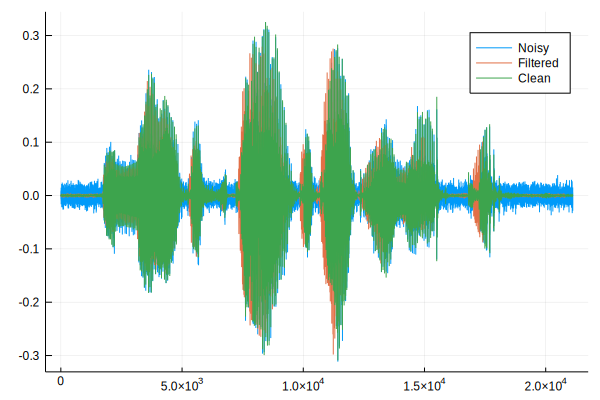

In [152]:
wavwrite(cleanSpeech, "speech/filtered.wav")

plot(ns, label="Noisy")
plot!(cleanSpeech, label="Filtered")
plot!(cl, label="Clean")

In [136]:
# filtered speech
cleanSpeech = reshape(cleanSpeech, length(cleanSpeech), 1)
buf_fl = SampleBuf{Float64, 2}(cleanSpeech, fs)

21119-frame, 1-channel SampleBuf{Float64, 2}
2.639875s sampled at 8000.0Hz
▂▂▂▂▂▂▄▅▅▄▅▅▅▆▆▆▆▅▄▃▅▅▂▂▂▄▂▅▆▆▆▆▆▆▅▄▂▅▅▃▅▆▆▆▆▃▃▅▅▅▅▅▄▅▅▅▅▅▂▂▂▂▂▂▅▅▄▃▂▂▂▂▂▂▂▂▂▂▂▁

In [137]:
# noised speech
buf_ns = SampleBuf{Float64, 2}(ns, fs)

21119-frame, 1-channel SampleBuf{Float64, 2}
2.639875s sampled at 8000.0Hz
▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▅▄▅▆▅▄▄▅▄▄▆▆▆▆▆▆▆▅▅▅▅▅▄▆▆▆▆▅▄▅▅▅▆▆▅▅▅▆▆▆▆▄▄▄▄▄▄▅▅▅▄▄▄▄▄▄▄▄▄▄▄▄

In [138]:
; python helpers/spectrograms.py

/Users/albertpod/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:7747: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


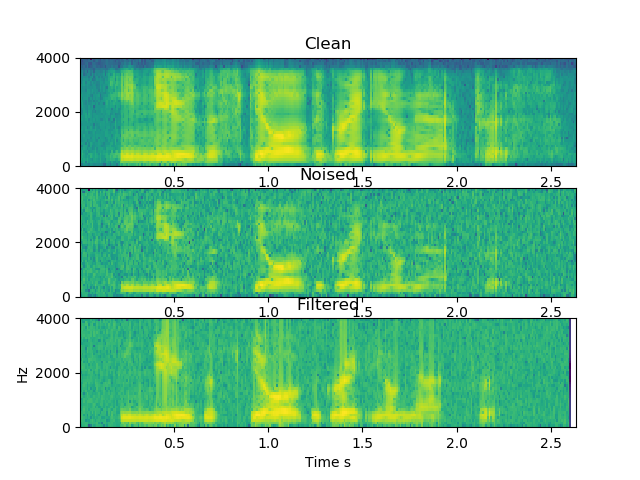

In [139]:
img = load("img/result.png")